In [1]:
!pip install -qr requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import ddim.models as models
from ddim.models.model_utils import load_params, get_default_channel_mult
from ddim.diffusion.parameters import linear_beta_schedule, diff_params_from_betas, respace_betas
from ddim.diffusion.inference import denoising_loop, denoising_loop_respaced

import numpy as np
import random

import jax
from jax import numpy as jnp
from jax.experimental.pjit import pjit, PartitionSpec
from jax.experimental.maps import mesh

import jmp

In [3]:
# Config
config = {
    "seed": 1337,
    "mesh_shape": (1, 4, 2),
    "prefix": "with_decay",
    "resume": 8800000,
    "data": {
        "image_size": 128,
        "image_channels": 3,
    },
    
    # UNet config (like OpenAI)
    "model_type": "UNet",
    "model": {
        "model_channels": 128,
        "channel_mult": (1, 1, 2, 3, 4),
        "num_head_channels": 64,
        "use_scale_shift_norm": True,
        "num_res_blocks": 2,
        "attention_resolutions": (32, 16, 8),
    },
    "diffusion": {
        "schedule_steps": 1000,
    }
}

In [4]:
# Jax setup
devices = np.array(jax.devices()).reshape((1, 4, 2))
precision_policy = jmp.Policy(
    compute_dtype = jnp.bfloat16,
    param_dtype = jnp.bfloat16,
    output_dtype = jnp.float32,
)

In [5]:
# Set up model
prefix = config["prefix"]
resume = config["resume"]
model_fun = getattr(models, config["model_type"])

config["model"]["out_channels"] = config["data"]["image_channels"]
config["model"]["dtype"] = precision_policy.compute_dtype
config["model"]["dtype_out"] = precision_policy.compute_dtype

model = model_fun(**config["model"])

if config["resume"] is None:
    assert("This is the inference notebook, specify a checkpoint!")
else:
    params = load_params(f"params_{prefix}_{resume}.pkl", devices)
    # TODO: Restore optimizer state?
    
params = precision_policy.cast_to_param(params)

"""
param_count = 0
for param in jax.tree_util.tree_flatten(params)[0]:
    param_count += len(param.flatten())
print(f"param count: {param_count}")
"""

# Initialize diffusion
betas = linear_beta_schedule(config["diffusion"]["schedule_steps"])
diff_params = diff_params_from_betas(betas)
diff_params_respaced = diff_params_from_betas(respace_betas(betas, 25))

/home/lorenzd/.local/lib/python3.8/site-packages/jax/experimental/pjit.py:160: UserWarning: pjit is an experimental feature and probably has bugs!
  warn("pjit is an experimental feature and probably has bugs!")


In [6]:
# pjit the denoising loop
def denoising_loop_pjit(params, diff_params, images):
    return denoising_loop(model, params, diff_params, images)

denoising_loop_pjit = pjit(denoising_loop_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
   # static_argnums = (0,) # TODO
)

# pjit the denoising loop, respaced edition
def denoising_loop_respaced_pjit(params, diff_params, images):
    return denoising_loop_respaced(model, params, diff_params, images)

denoising_loop_respaced_pjit = pjit(denoising_loop_respaced_pjit, 
   [
       PartitionSpec(None),
       PartitionSpec(None),
       PartitionSpec("batch", "x", "y")
   ], 
   PartitionSpec("batch", "x", "y"),
   # static_argnums = (0,) # TODO
)

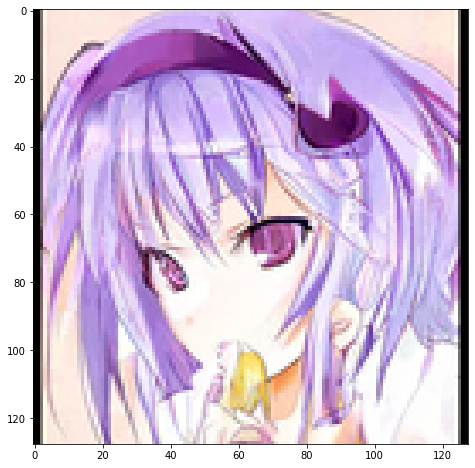

In [7]:
# Single image
prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
images_in = jax.random.normal(prng_img, (1, 128, 128, 3))
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))
image = np.array(((out[0, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

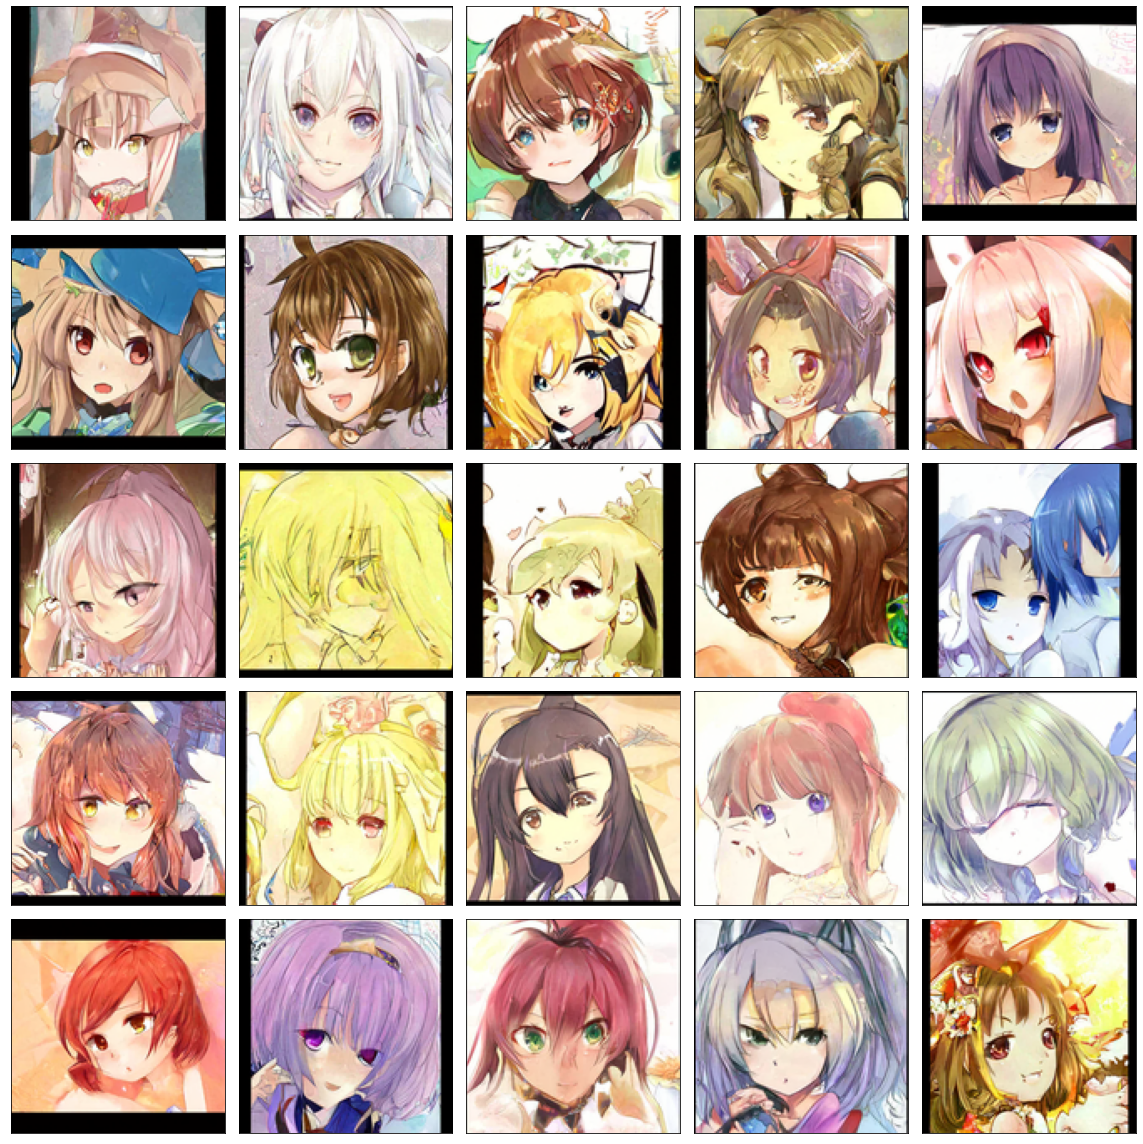

In [8]:
# Batch inference
temp = 1.0
prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
images_in = jax.random.normal(prng_img, (25, 128, 128, 3)) * temp
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_pjit(params, diff_params, images_in.astype(jnp.float32))
    
plt.figure(figsize=(16, 16))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = np.array(((out[i, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("out.png")
plt.show()

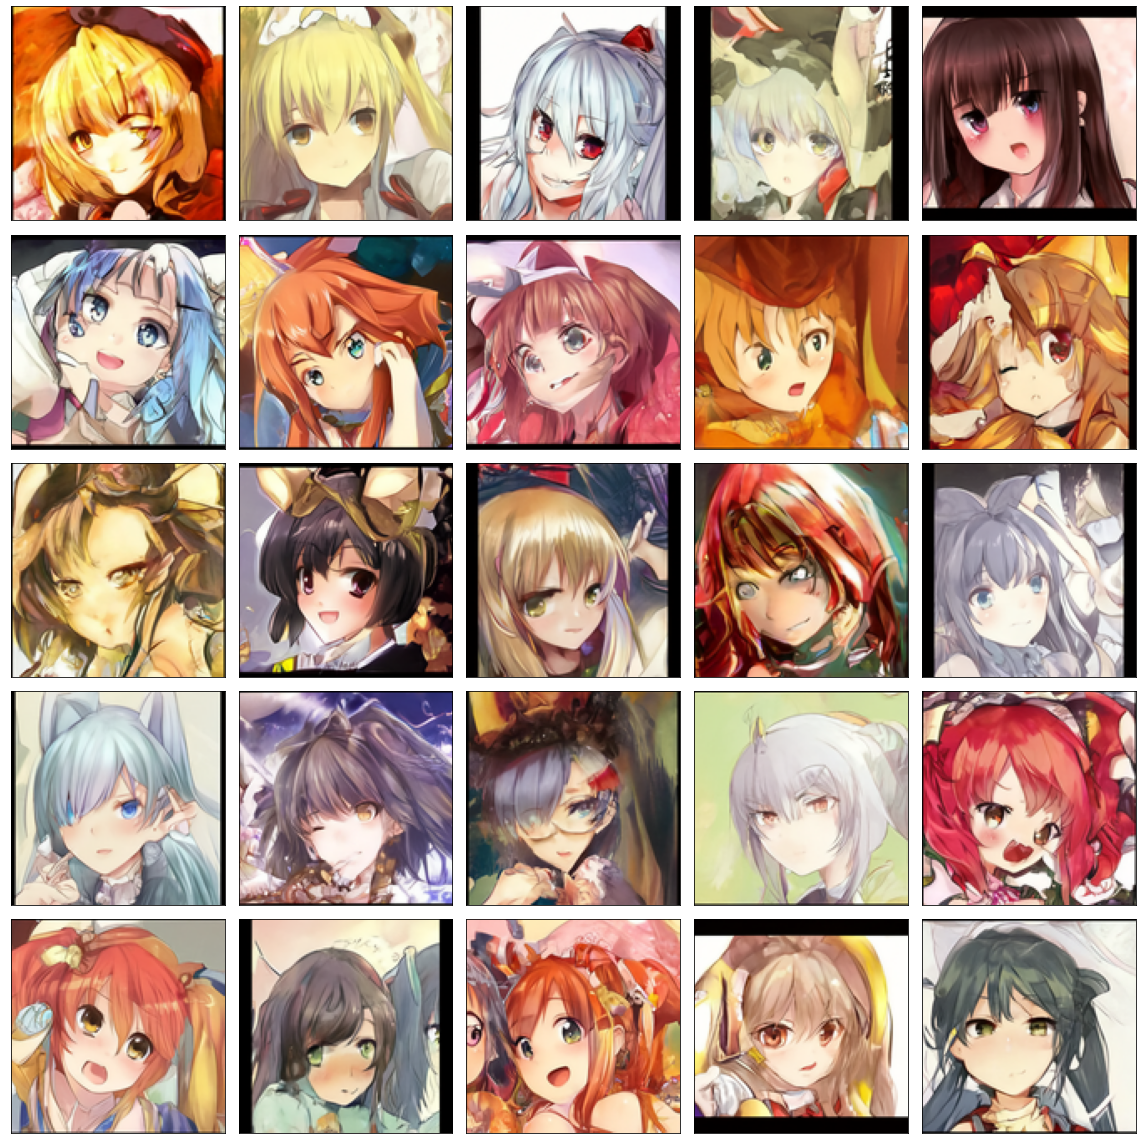

In [9]:
# Batch inference, respaced denoising
temp = 1.0
prng_img = jax.random.PRNGKey(random.randint(0, 2**32))
images_in = jax.random.normal(prng_img, (25, 128, 128, 3)) * temp
with mesh(devices, ('batch', 'x', 'y')):
    out = denoising_loop_respaced_pjit(params, diff_params_respaced, images_in.astype(jnp.float32))
    
plt.figure(figsize=(16, 16))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = np.array(((out[i, :, :, :] + 1.0) * 127.5)).astype(np.uint8)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig("out2.png")
plt.show()